---
title: "Writing Stable Diffusion from Scratch 7"
reading-time: 
date: "2023-3-27"
categories: [fastaipart2,Stable-Diffusion]
---

All credits goes to fast.ai <br>
All mistakes are mine. <br>
I have to put code from previous lessons scence they are connected. 

You should know and practice following after this blog post : 
1- Refactor pervious code to make it cleaner <br>
2- Know how nn module works in pytorch <br>
3- how setattr works ? <br>
4- __repr__ ? <br>
5- yeild from ? <br>
6- supper() and object ? <br>
7- reduce, map ? <br>
8- optimizer <br>
9- learning rate ? <br>
10- Sampler <br>
11- Collate function <br> 
12- Multi processing data loader <br>


In [1]:
#| default_exp training

In [2]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F

In [4]:
from fastcore.test import test_close

mpl.rcParams['image.cmap'] = 'gray'
torch.set_printoptions(precision=2, linewidth=125, sci_mode=False)
np.set_printoptions(precision=2, linewidth=125)

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'

In [5]:
from urllib.request import urlretrieve
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [6]:
!ls -l data

total 16656
-rw-r--r-- 1 root root 17051982 Mar 29 06:53 mnist.pkl.gz


In [7]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [8]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [9]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [10]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.

In [11]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [12]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [13]:
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [14]:
def logsumexp(x):
    m = x.max(-1)[0]
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [15]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [16]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [17]:
y_train[:3]

tensor([5, 0, 4])

In [18]:
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [19]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [20]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [21]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [22]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [23]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [24]:
loss_func = F.cross_entropy

In [25]:
bs=50                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([50, 10]))

In [26]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7,
        6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3])

In [27]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [28]:
preds.argmax(dim=1)

tensor([3, 9, 3, 8, 5, 9, 3, 9, 3, 9, 5, 3, 9, 9, 3, 9, 9, 5, 8, 7, 9, 5, 3, 8, 9, 5, 9, 5, 5, 9, 3, 5, 9, 7, 5, 7, 9, 9, 3,
        9, 3, 5, 3, 8, 3, 5, 9, 5, 9, 5])

In [29]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [30]:
accuracy(preds, yb)

tensor(0.08)

In [31]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [32]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [33]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.08


In [34]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'):
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_()
    report(loss, preds, yb)

0.11, 0.96
0.13, 0.96
0.10, 0.96


## Using parameters and optim

And so we're now going to I'm going to show you something that's part of pytorch and then going to show you how to build it, and then you'll see why this is really useful. So PyTorch  has a sub Module starting nn. And in there there's something called the Module class. Now we can we don't normally use it this way, but I just want to show you how it works. We can create an instance of it in the usual way we create instances of classes and then we can assign things to attributes of that module. So for example, it's assign a linear layer to it. And if we now print out that, you'll see it says, Oh, this is a module containing something called f00, which is a linear layer. But here's something quite tricky. This module we can say, show me all of the named children of that module and it says, Oh, this one code foo and it's a linear layer. And we can say, Oh, show me all of the parameters of this module. And it says, Oh, okay, sure. There's two of them. There's this four by three tensor, that's the weights and there's this four long vector. That's the biases. And so somehow just by creating this module and assigning this to it, it's automatically tracked what's in this module and what are its parameters. That's pretty neat. So we're going to see both how and why it does that. I'm just going to point out, by the way, why did I add list here? If I just said m1.named_children(), it just prints out generate an object which is not very helpful and that's because this is a kind of iterator called a generator, and it's something which is going to only produce the contents of this when I actually do something with it, such as list them out. 

So just popping a list around a generator is one way to like run the generator and get its output. That little trick when you want to look inside a generator. 

Okay, so now, as I said, we don't normally use it this way. What we normally do is we create our own class. So, for example, we create our own multilayer perception and we inherit it. We inherit from a nn.Module. And so then in __init__, this is the thing that constructs an object of the class. This is the special magic method that does that well, say, okay, well, how many inputs are there to this multilayer perceptron? How many hidden activations and how many output activations are there? So just be one hidden layer. And then here we can do just like we did up here, where we assign things as attributes. We can do that in this constructor, so we create an l1 attribute, which is a linear layer from number into number. Hidden l2 is a linear layer from number hidden number out, and we'll also create a relu. And so when we call that module(__call__), we can take the input that we get and run the linear layer and then run the relu here and then run the l2. And so I can create one of these, as you say, and I can have a look and see like, Oh, here's the attribute l1 and there it is, like I said, and I can say print out the model and the model knows all the stuff that's in it. And I can go through each of the named children and print out the name and the layer. Now, of course, if you're a member, although you can use __call__, we actually showed how we can refactor things using forward such that it would automatically kind of do the things necessary to make all the, you know, or automatic gradient stuff work correctly.

 And so in practice we're actually not going to do it __call__ we would do forward. So this is an example of creating a custom PyTorch module. And the key thing to recognize is that it knows what are the attributes you added to it, and it also knows what all the parameters. 

So if I go through the parameters and print out the shapes, you can see I've got my linear layers, weights first,  my first linear layers weights, my first linear layers biases second linear layers weights, second linear layers biases. And this is because we set nh, the number of hidden to 50. 

So why is that interesting? Well, because now I don't have to write all this anymore. Going through layers and having to make sure that they've all been put into a list where you've just been able to add them as attributes and they're automatically going to appear as parameters. So we can just say, go through each parameter and update it based on the gradient and the learning rate. And furthermore, you can actually just go model.zero_grad and it'll zero out all of the gradients. So that's really made our code quite a lot nicer and quite a lot more flexible, which is cool. 
we do 

So let's check that this still works. There we go. So just to clarify with if I called report on this before I ran it, as you would expect, the accuracy is about 8% with about 10% less and the loss is pretty high. And so after I run this fit this model, the accuracy goes up and the loss goes down. So basically it's all of this is exactly the same as before. The only thing I've changed are these two lines of code, so that's a really useful refactoring. So what how on earth did this happen? How did it know what the parameters and layers are? Automatically it used a trick called dunder __setattr__. and we're going to create our own and nn.module. 

### Parameters

In [35]:
m1 = nn.Module()
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [36]:
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [37]:
m1.named_children()

<generator object Module.named_children at 0x7f64aaeec190>

In [38]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True), Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [39]:
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [40]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [41]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [42]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [43]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [44]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [45]:
fit()

0.19, 0.96
0.11, 0.96
0.04, 1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

Now. So if there was no such thing as an nn.module, here's how would build it. And so let's actually build it and also add some things to it. So in __init__, we would have to create a dictionary for our named children. This is going to contain a list dictionary of all of the layers. Okay. And then just like before, we'll create a couple of linear layers, right? And then what we're going to do is going to define this special magic thing that Python has __setattr__. And this is called automatically by Python if you have it, every time you set an attribute such as here or here and it's going to be past the name of the attribute, the key and the value is the actual thing on the right hand side of the equals sign. Now, generally speaking, things that start with an underscore where we use for either private stuff. So we check that it doesn't start with an underscore. And if it doesn't start with an underscore, __setattr__ will put this value into the modules dictionary with this key and then call Python's the normal python __setattr__, try to make sure it just actually does the attribute setting. So super is how you call whatever is in the the superclass, the base class. So another useful thing to know about is how do we how does how does it do this nifty thing where you can just type the name and it kind of lists out all this information about it.

 That's a special thing called __repr__. So here,  __repr__ will just have it return a stringified version of the module's dictionary. And then here we've got parameters. How did parameters work? So how did this thing work? Well, we can go through each of those modules, go through each value. So the values of the modules is all the actual layers and then go through each of the parameters in each module and yield p.  So that's going to, that's going to create an iterator. If you remember when we looked at iterates for all the parameters, So let's try it so we can create one of these modules. 
 
 there they are now just mentioned something that's optional, kind of like advanced Python that a lot of people don't know about, which is there's no need to loop through a list or a generator or I guess I say look for an iterator and yield. There's actually a shortcut, which is you can just say yield from and then give it the iterator. 
 
 And so with that we can get this all down to one line of code and it'll do exactly the same thing. So that's basically saying yield one at a time. Everything in here, that's what yield from does. So there's a little advanced python thing, totally optional. But if you're interested I think it can be kind of neat.

 

In [46]:
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v)

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [47]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [48]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


So we've now learned how to create our own implementation of an   nn.module and therefore we are now allowed to use pytouches      nn.module. So that's good news. So how would we do using the PyTorch and nn.module? How would we create the model that we started with, which is where we had this self,layers because we want to somehow register all of these all at once? That's not going to happen based on the code we just wrote. So to do that, let's have a look. We can so let's make a list of the layers we want. And so we'll create again, a subclass of nn.module. Make sure you call the super classes in it first(super()__init__) and we're just store list of layers. And then to tell PyTorch about all those layers, we basically have to loop through them and call add_module and say what the name of the module is and what the module is. And again, because should probably should have used forward to here in the first place and you can say this is now done exactly the same thing. Okay. So if you've used a sequential model before, you'll see or you can say that we're on the path to creating a sequential model. 

Okay. So Gonash asked an interesting question, which is what on earth is super calling? Because we actually in fact, we don't even need the parentheses here. We actually don't have a base class. That's because if you don't put any parentheses or if you put empty parentheses, it's actually a shortcut for writing that. And so Python has stuff in object which does, you know, all the normal object, things like storing your attributes so that you can get them back later. So that's what's happening there. Okay. 

So this is a little bit awkward is to have to store the list and then enumerate and call add_module. So now that we've implemented that from scratch, we can use PyTorch is version, which is they've just got something called ModuleList that just does that for you. Okay. So if you use ModuleList and pass that list of layers, it will just go ahead and register them all those modules for you. So here's something called sequential model. So this is just like    nn.sequential now. So if I create it passing in the layers, there you go. You can see that's my module containing my module list with my layers. And so to know why I never used forward for these things, it's silly because it doesn't add a terribly in this stage. But anyhow, okay, so call fit. And there we go. Okay, so, so in forward here, I just go through each layer and I set the result of that equal to calling that layer on the previous result and then pass and return it at the end. 

### Registering modules

In [49]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [50]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

Now there's little another way of doing this, which I think is kind of fun. It's not like shorter or anything at this stage. I just wanted to show an example of something that you see quite a lot in machine learning code, which is the use of reduce. 

This implementation here is exactly the same as this thing here. So let me explain how it works. A lot reduced. So reduced is a very common kind of like fundamental or computer science concept reductions. This is something that does a reduction.

 And what a reduction is??
 
 is it's something that says start with the third parameter, some initial value. So we're going to start with x, the thing with being passed and then loop through a sequence. So look through each of our layers and then for each layer, call some function. Here is our function and the function is going to get passed. First time around, it'll be past the initial value and the first thing in your list. So your first layer and x. So it's just going to call the layer function on x the second time around to take the output of that and passes that in as a second as the first parameter and passes in the second layer. So then the second time this goes through, it's going to be calling the second layer on the result of the first layer and so forth, and that's what a reduction is. And so you might see reduce, you'll certainly see it talked about quite a lot in in papers and books and you might sometimes also see it in code. It's a very general concept. And so here's how you can implement a sequential model using reduce. So there's no explicit loop there, although it's still happening internally. 
 
 

In [51]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [52]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [53]:
model(xb).shape

torch.Size([50, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [54]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [55]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [56]:
fit()

0.12, 0.96
0.11, 0.96
0.07, 0.98


All right. So now that we've re implemented sequential, we can just go ahead and use PyTorch as version.there's an nn.Sequential we can pass in our layers and we can fit, not surprisingly, we can see the model. So yeah, it looks very similar to the one we built ourselves. All right. 



### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [57]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [58]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.16, 0.94
0.13, 0.96
0.08, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

In [59]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

So this thing of looping through parameters and updating our parameters based on gradients and aligning right and then zeroing them is very common.

So common that there is something that does at all for us and that's called an optimizer. It's the stuff in Optim. So let's create our own optimizer.
 And as you can see, it's just going to do the two things we just saw.

1-It's going to go through each of the parameters and update them using the gradient in the lending rate. 

2-And there's also zero grad which will go through each parameter and set their gradients to zero.

 If you used .data like it's just a way of avoiding having to say touch.no_grid basically. 
 
 Okay, so in Optimizer we're going to pass at the parameters that we want to optimize. I'm going to pass at the learning, right? And we're just going to store them away. And since the parameters might be a generator, we'll call list to turn them into a list. So we are going to create our optimizer, pass it in the model. parameters which have been automatically constructed for us by an nn.module. And so here's our new loop. Now, we don't have to do any of the stuff manually. We can just say opt.step. So that's going to call this and opt.zero_grad and that's going to call this. There it is. So we've now built our own SGD optimizer from scratch. 
 
So I think this is really interesting right?
Like these things which seem like they must be big and complicated once we have this nice structure in place, you know, an SGD to optimize, it doesn't take much code at all. And so it's all very transparent, simple clear. If you're having trouble using complex library code that you've found elsewhere, you know, this can be a really good approach is to actually just go all the way back and move as you know, as many of these abstractions as you can and like run everything by hand to see exactly what's going on. It can be really freeing to see that you can do all this anyway, since PyTorch has this for us In torch.optim. It's got a optim.SGD. And just like our version, you pass in the parameters and you pass in the learning, right? So you really see it is just the same. So let's define something called get model that's going to return the model, the sequential model and the optimizer for it. So if we go model, comma opt equals get model, and then we can call the lost function to see where it's starting. And so then we can write our training loop again, go through each epoch, go through each starting point for our for our batches, grab the slice, slice into our x and y in the training set to get a predictions, calculate our loss to the backward pass, to the optimizer, step to the zero gradient and print out how you're going at the end of each one. And then we go, 

### optim

In [60]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [61]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [62]:
opt = Optimizer(model.parameters())

In [63]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.18, 0.94
0.13, 0.96
0.11, 0.94


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [64]:
from torch import optim

In [65]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [66]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.33, grad_fn=<NllLossBackward0>)

In [67]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.12, 0.98
0.09, 0.98
0.07, 0.98


## Dataset and DataLoader

All right, so let's keep making this simpler. This don't say much code. So one thing we could do is we could replace these lines of code with one line of code by using something, call the dataset class. 

So the dataset class is just something that we're going to pass in our independent and dependent variable. Well, store them away as self.x and self.y. Why we'll have something. So if you if you define __len__, then that's the thing that allows the len function to work. So the length of the dataset would just be the length of the independent variables. 

And then  __getitem__ is a thing that will be called automatically any time you use square brackets in Python. So that task is going to call this function passing in the indices you want. So when we grab some items from our dataset, we're going to return a couple of the x values and the y values. 


So then we'll be able to do this. So let's create a data set using this tiny little tree line class. it's going to be a dataset containing the x and y training, and they'll create another dataset containing the x and y valid. And those two datasets will call train_ds and valid_ds. So let's check the length of those data sets should be the same as the length of the xs and they are. And so now we can do exactly what we hope we could do. We can say xb,yb equals train_ds and passing some slice. So that's going to give us back our check The shapes are correct. It should be five by 28, by 28. And the y is should just be five. And so here they are, the xs and the y's. So that's nice. We've created a dataset from scratch and again, it's not complicated at all. And if you look at the actual PyTorch source code, this is basically your data sets do so let's try it. We call get_model() And so now we've replaced our dataset line with this one and as usual it still runs. And so this is what I do when I'm writing code is I try to like always make sure that my starting code works as I refactor. And so you can see all the steps. And so somebody reading my code can then see exactly like, why am I building everything I'm building? How does it all fit in? Say that it still works and I can also keep it clear in my own head. So I think this is a really nice way of implementing libraries as well. All right. So now we're going to replace these two lines of code with this one line of code. So we're going to create something called a data loader.



### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [68]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [69]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [70]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([5, 0, 4, 1, 9]))

In [71]:
model,opt = get_model()

In [72]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.17, 0.96
0.11, 0.94
0.09, 0.96


### DataLoader

So now we're going to replace these two lines of code with this one line of code. So we're going to create something called a data loader. And a data loader is something that's just going to do this. Okay. So we need to create an iterator. So an iterator is a class that has a __iter__ method. When you say for in in Python behind the scenes, it's actually calling __iter__ to get a special object, which it can then loop through using yield. So it's basically getting this thing that you can iterate through using the yield. So a data loader is something that's going to have a data set and a batch size because we're going to go through the batches and grab one batch at a time. So we have to store away the data set in the batch size. And so when we when we call the for loop, it's going to code __iter__. We're going to want to do exactly what we saw before, go through the range just like we did before, and then yield that bit of the data set. And that's all. So that's a data letter. So we can now create a train data loader and a validator loader from our train data set and validator set. And so now we can, if you remember the way you can create one thing out of an iterator so you don't need to use a for loop, you can just say __iter__. And that will also code and data. Next, we'll just grab one value from it. So here we will run this and you can see we've now just confirmed wave xb is a 50 by 784. And why yb, there it is. And then we can check what it looks like. So let's grab the first element of our x batch, make it 28 by 28. And there it is. So now that we've got a date loader again, we can grab our model and we can simplify our fit function to just go for xb,yb and train_dl.




Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [73]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [74]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [75]:
xb,yb = next(iter(valid_dl))
xb.shape

torch.Size([50, 784])

In [76]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7,
        6, 8, 9, 0, 3, 8, 3, 7, 7, 8, 4])

tensor(3)

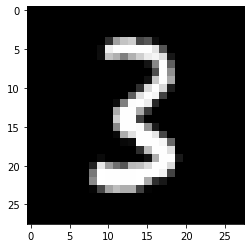

In [77]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [78]:
model,opt = get_model()

In [79]:
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            pred = model(xb)
            loss = loss_func(pred, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [80]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.11, 0.96
0.09, 0.96
0.06, 0.96


(tensor(0.03, grad_fn=<NllLossBackward0>), tensor(1.))

### Random sampling

 So this is getting nice and small, don't you think? And it still works the same way. Okay, so this is really cool. And now that it's nice and concise, we can start adding features to it. So one feature I think we should add is that our training set each time we go through it, it should be in a different order. It should be randomized the order. So instead of always just going through these indexes in order, we want some way to say use random indexes. So the way we can do that is create a class called sampler. And what sampler is going to do here is if we create a sampler without shuffle, without randomizing it, it's going to simply return all the numbers from zero up to n in order and it'll be an iterator. 

So the way we can do that is create a class called sampler. And what sampler is going to do here is if we create a sampler without shuffle, without randomizing it, it's going to simply return all the numbers from zero up to end in order and it'll be an iterator. So this is done data, but if I do want to, then it will randomly shuffle them. So here you can see I've created a sampler without shuffle. So if I then make an iterator from that and print a few things in the iterator, you can see it's just printing out the indexes. It's going to want, or I can do exactly the same thing as we learned earlier in the course using Isolés, we can grab the first five. So here's the first five things from a sampler when it's not shuffled. So as you can see, these are just indexes. So we could add shuffle equals true. And now that's going to call random dot shuffle, which just randomly permits them. And now if I do the same thing, I've got random indexes. If my source data. So why is that useful? Well, what we can now do is create something called a batch sampler, and the batch sampler is going to do is it's going to basically do this isolates thing for us. So we're going to say, okay, pass in a sampler, set something that generates indices and pass in a batch size. And remember, we've looked at chunking before. It's going to chunk that iterator by that batch size. And so if I now say, all right, please take our sampler and create batches of four, as you can see here, it's creating batches of four indices at a time. So rather than just looping through them in order, I can now loop through this batch sampler. So we're going to change our data loader so that now it's going to take some batch sampler and it's going to look through the batch sampler that's going to give us indices and then we're going to get that data set item from that batch for everything in that batch.

So that's going to give us a list and then we have to stack all of the (x es) and all of the (y eys) together into tensers. So I've created something here called Collate function and we're going to default that to this little function here, which is going to grab our batch, pull out the (x es) and (y eys) separately, and then stack them up into tensors. So this is called our collate function. Okay, So if we put all that together, we can create a training sampler, which is a batch sampler over the training set with shuffle True, a validation sampler will be a batch sampler over the validation set with shuffle false. And so then we can pass that into this data loader class, The training data set and the training sampler and the COLLATE function, which we don't really need because we're just using the default one. So I guess we can just get rid of that. And so now here we go. We can do exactly the same thing as before. xb,yb =next(iter(valid_dl)) this time we use the validator loader, check the shapes. And so now check. That still works. And it does. So this is how PyTorch is actual data loaders work. This is the this is all the pieces they have. They have samplers, they have batch samplers, they have a collation function and they have data letters. So remember that what I want you to be doing for your homework is experimenting with these carefully to see exactly what each thing is taking in. Okay, so here is asking on the chat what is this collate thing doing?

 Okay, so collate function and it defaults to collate. What does it do? Well, let's see. Let's go through each of these steps. Okay, so we need so we've got a batch sampler. So let's do just the valid sampler. No fit didn't work. We have to look at that to. Okay, so the batch sampler, here it is. So we're going to go through each thing in the batch sampler. So let's just grab one thing from the batch sampler. Okay? So the output with the batch sampler will be next. It's a okay, so here's what the batch sampler contains. All right. Just the first 50 digits, not surprisingly, because this is a validation sampler. If we did a training sampler, that would be randomized. Yeah, they are. Okay, so then what we then do is we go self.ds[i] for i and b, so let's copy that copy paste. And so rather than self.ds[i] will just say train_ds[i] for i in o ,Sorry. Training. Okay. So what it's created here is a list of tuples of tensors, I think. Let's have a look. So let's have a look. So we'll call this a whatever. So p zero. Okay, is a tuple. It's got the x and the y independent, independent variable. So that's not what we want. What we want is something that we can live through. We want to get batches. So what the collation function is going to do is it's going to take all of our x's and all of our y's and collect them into two tensors, one tensor x's and one tensor y's. So the way it does that is it. First of all, calls zip. So zip is a very, very commonly used python function. It's got nothing to do with the compression program zip. But instead what it does is it effectively allows us to like transpose things so that now, as you can see, we've got all of the second elements, index one elements all together and all of the index zero elements together. And so then we can stack those all up together and that gives us our y`s for our batch. So that's what collate it does. So the collate function is used an awful lot in in PyTorch increasingly nowadays where hackingface stuff uses it a lot and so we'll be using it a lot as well. And basically it's a thing that allows us to customize how the data that we get back from our dataset set. Once it's been kind of generating a list of things from the dataset, how do we put it together into some into a bunch of things that our model can take as inputs, because that's really what we want here. So that's what the collection function does. All right. So let's try this again. And the reason these are wrong, it'll be something to do with a report. It's a accuracy. So something about the accuracy is not printing out correctly. Let's see if we can figure it out. So probably does it down here. Yeah, it'd be something to do with that shuffling. If we tend to shuffle off, probably find out our work. Yes, it does. Okay, sir, my shuffling bracket. Hmm. Oh, I see why this should be preds. Better.So when we run our model and we call fit(), we get the same results. One trick I was just going to mention normally in __init__ the way we we very, very often want to grab all the stuff that we've been passed as parameters and store it away like so this is the wrong way around. Like so this is something that I do so often that fast core has a quick little shortcut for it. Just called Store at Trust all attributes. And so if you just put that in your __init__, then you just need one line of code and it does exactly the same thing. So there's a little shortcut as you see. And so you'll see that quite a bit. All right, let's have a seven minute break and see you back here very soon. 

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [81]:
import random

In [82]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [83]:
from itertools import islice

In [84]:
ss = Sampler(train_ds)

In [85]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [86]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [87]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 5))

[28659, 39049, 23211, 13983, 38058]

In [88]:
import fastcore.all as fc

In [89]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [90]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[7445, 36933, 36891, 13229],
 [47783, 46860, 1239, 20962],
 [8646, 29897, 9202, 31355],
 [48398, 35167, 44700, 27769],
 [7834, 22128, 40411, 5830]]

In [91]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [92]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr()
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [93]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [94]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

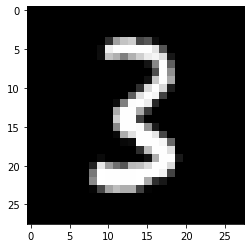

In [95]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [96]:
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

In [97]:
model,opt = get_model()

In [98]:
fit()

0.33, 0.12
0.22, 0.06
0.02, 0.04


### Multiprocessing DataLoader

And we're going to look at a multi processing data loader and then we'll have nearly finished this notebook.
 
All right. So you send it because wants to know how it implements store_attr. You can always look it up. Right. So if we could go look at here is the docs and there's always a link to the source. Yeah, go. You can create a version that's a lot less code than this. This is dealing with a few extra things like slots and store_args and stuff. So basically the trick is to see who's calling you using some rather internal ish stuff on code. All right, let's keep going. So we've seen how to create a data loader and sampling from it. The PyTorch data loader works exactly like this, but it uses a lot more code because it implements multi processing. And so multi processing means that the actual this thing here, that code can be run in multiple processes, that can be run in parallel for multiple items. So this code, for example, might be opening up a jpeg, rotating it, flipping it, etc.. Right. So because remember, this is just calling the __getitem__ for a data set. So that could be doing a lot of work for each item and we're doing it for every item in the batch. So we'd love to do those all in parallel. So I'll show you a very quick and dirty way that basically does the job. So Python has a multiprocessor library. It doesn't work particularly well with PyTorch tensors, so PyTorch has created an exact implementation of it. So it's identical API wise, but it does work well with tensors. So this is basically what a script the multi processing. So this is not quite shading because multi processing is in the standard library and this is API equivalent. So I'm going to say we're allowed to do that. So as we've discussed, you know, when we call square brackets on a class, it's actually identical to calling the __getitem__ function on on the object. So you can see here, if we say give me items three, six, eight and one, it's the same as calling __getitem__ passing in three, six, eight and one.

 Now why does this matter??
 
Well I'll show you why it matters because we're going to be able to use map and explain why we want to use map the moment map is a really important concept. You might have heard of MapReduce. So we've already talked about reductions and what those are maps are kind of the other key piece map is something which takes a sequence and calls a function on every element of that sequence.

 So imagine we had a couple of batches of indices three and six and eight and one. Then we're going to call __getitem__ on each of those batches. So that's what map does. map calls this function on every element of the sequence. And so that's going to give us the same stuff. But now this, same as this, but now batched into two batches. Now why do we want to do that? Because multi processing has something called Pool where you can tell it. How many workers do you want to read and how many processes you want to run? And it then has a map which works just like the python normal python map, but it runs this function in parallel over the items from this iterator. So this is how we can create a multi processing data loader. So here we are creating our data loader and again, we don't actually need to pass in the collate function because we using the default one. So if we say n_workers  equals two and then create that if we say next, see how it's taking a moment took a moment because it was firing off those two workers in the background. So the first batch actually comes out more slowly. But the reason that we would use a multi processing data loader is if this is doing a lot of work, we want it to run in parallel. And even though the first  item might come out a bit slower, once those processes are fired up, it's going to be faster to run. So this is yeah, this is a really simplified multi processing data loader because this needs to be super, super efficient. PyTorch has lots more code than this to make it much more efficient. But the idea is this and this is actually a perfectly good way of experimenting or building your own data loader to make things work exactly how you want. So now that we've really implemented all this from PyTorch, let's just grab the PyTorch. And as you can see, they're exactly the same data laoder. They don't have one thing called sampler that you pass shuffle to. They have two separate classes called sequential sampling random sampler. I don't know why they do it that way. It's a bit more work to me, but same idea. And they've got that sampler. And so it's exactly the same idea. That training sampler is a batch sampler with a random sampler. The validation sampler is a batch sampler with a sequential sampler passing in batch sizes. And so we can now pass those samplers to the data loader. This is now the PyTorch data letter. And just like ours, it also takes a collate function. Okay. And it works cool. So that's as you can see, it's it's doing exactly the same stuff that ours is doing with exactly the same API. And it's got some shortcuts, as I'm sure you've noticed when you've used data loaders.
 
So, for example, calling batch sampler is very going to be very, very common. So you can actually just pass the batch size directly to a data loader and it will then auto create the batch samples for you so you don't have to pass in batch sampler at all. Instead, you can just say sampler and it will automatically wrap that in the batch sampler for you. That does exactly the same thing. And in fact, because it's so common to create a random sampler or a sequential sampler for a data set, you don't have to do that manually. You can just pass in shuffle equals true or shuffle equals false to the data loader. And that does again, exactly the same thing. There it is. 

Now, something that is very interesting is that when you think about it, the batch sampler and the collation function are things which are taking the result of the sampler looping through them and then collating them together. But what we could do is actually because our datasets know how to grab multiple indices at once, we can actually just use the batch sampler as a sampler. We don't actually have to look through them and collate them because they're basically instantly collated. They come pre collated. So this is a trick which actually huggingface stuff can use as I won't be saying it again. So this is an important thing to understand is how come we can pass a batch sample to the sampler. What's it doing?

 And so rather than trying to look through the PyTorch code, I suggest going back to our non multi processing pure Python code to see exactly how that would work, because it's a really nifty trick for things that you can grab multiple things from at once and it can save a whole lot of time. It can make your code a lot faster. Okay, so now that we've got all that nicely implemented, 
 
 

In [99]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [100]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1, 1, 0]))

In [101]:
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1, 1, 0]))

In [102]:
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [103]:
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [104]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [105]:
xb,yb = next(it)
xb.shape,yb.shape

(torch.Size([50, 784]), torch.Size([50]))

### PyTorch DataLoader

In [106]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [107]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [108]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [109]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 0.06
0.10, 0.04
0.27, 0.06


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(0.98))

PyTorch can auto-generate the BatchSampler for us:

In [110]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [111]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [112]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.21, 0.14
0.15, 0.16
0.05, 0.10


(tensor(0.06, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [113]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [114]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [115]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 50, 784]), torch.Size([1, 50]))

## Validation

we should now add a validation set and there's not really too much to talk here. We'll just take our fit function. And this is exactly the same code that we had before. And then we're just going to add something which goes through the validation set and gets the predictions and sums up the losses and accuracies and from time to time prints out the loss and accuracy. And so get deals we will implement by using the PyTorch data loader now. And so now our whole process will be get deals passing in the training and validation data set that is set for our validation data loader. 

???I'm doubling the batch size because

 it doesn't have to do back propagation,???



so it should use about half as much memory. So I can use a bigger batch size, get our model and then call this fit. And now it's printing out the loss and accuracy on the validation set. So finally we actually know how we're doing, which is that we're getting 97% accuracy on the validation set, and that's on the whole thing, not just on the last batch. So that's cool. We've now implemented a proper working, sensible training loop. It's still, you know, a bit more code than I would like, but it's not bad. And every line of code in there and every line of code it's calling, it's all stuff that we have built ourselves, reimplemented ourselves. So we know what's going on. And that means it's going to be much easier for us to create anything we can think of. We don't have to rely on other people's code, so hopefully you're as excited about that as I am because it really opens up a whole world for us. 

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [116]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [117]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [118]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [119]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.14236383258365096 0.958100004196167
1 0.12564025239087642 0.9632000041007995
2 0.13069150418043138 0.9645000052452087
3 0.10988456704188138 0.9670000064373017
4 0.11636368061415851 0.9678000068664551
CPU times: user 6.57 s, sys: 25.2 ms, total: 6.59 s
Wall time: 6.66 s
